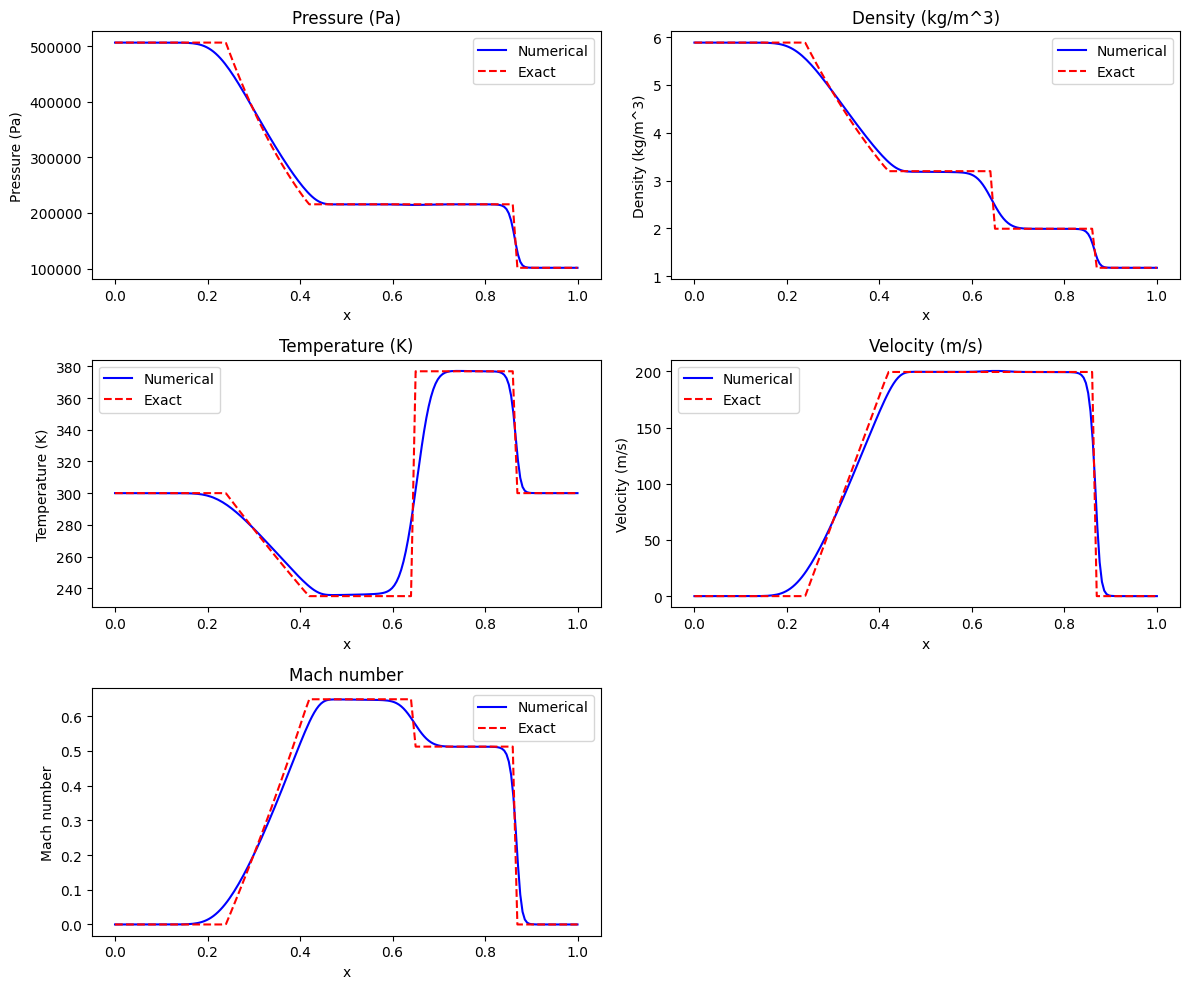

In [11]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

# Constants
gama = 1.4  # Specific heat ratio
R = 287  # Gas constant for air, J/(kg·K)
L = 1  # Length of the tube, m
N = 203  # Number of grid points
dx = L / (N - 1)  # Grid spacing
t_final = 0.75e-3  # End time of simulation, s
CFL = 0.6  # CFL number for stability

# Initial conditions
x = np.linspace(0, L, N)
p = np.where(x < 0.5, 5, 1) * 101325  # Pressure, Pa
T = np.full(N, 300)  # Temperature, K
density = p / (R * T)  # Density, kg/m^3
u = np.zeros(N)  # Velocity, m/s
E = p / (gama - 1) + 0.5 * density * u ** 2  # Internal energy per unit volume, J/m^3
a = np.sqrt(gama * R * T)  # Speed of sound, m/s
M = u / a  # Mach number
density_u = density * u  # Momentum density, kg/(m^2·s)

# Steger-Warming flux splitting method
def flux(density, density_u, E, u, p, a, gama):
    Fp = np.zeros((3, N)) # Initialize Flux matrix F plus
    Fm = np.zeros((3, N)) # Initialize Flux matrix F minus

    M = u / a

    for i in range(N):

        # Calculate flux based on the Mach number
        if M[i] <= -1: # For Mach number less than -1
            Fp[:, i] = np.array([0, 0, 0])
            Fm[:, i] = np.array([density[i] * u[i], density[i] * u[i] ** 2 + p[i], (E[i] + p[i]) * u[i]])

        elif M[i] >= 1: # For Mach number grater than 1
            Fm[:, i] = np.array([0, 0, 0])
            Fp[:, i] = np.array([density[i] * u[i], density[i] * u[i] ** 2 + p[i], (E[i] + p[i]) * u[i]])

        else:  # -1 < M(Mach number) < 1

            Fp[:, i] = 0.25 * density[i] * a[i] * (M[i] + 1) ** 2 * np.array([1, 2 * a[i] / gama * (1 + (gama - 1) / 2 * M[i]), 2 * a[i] ** 2 / (gama ** 2 - 1) * (1 + (gama - 1) / 2 * M[i]) ** 2])
            Fm[:, i] = np.array([density[i] * u[i], density[i] * u[i] ** 2 + p[i], (E[i] + p[i]) * u[i]]) - Fp[:, i]

    return Fp, Fm

# Calculating flux as increasing in time
t = 0 # start time (0 sec)
while t <= t_final:
    # Time step calculation
    dt = CFL * dx / np.max(np.abs(u) + a) # Lamda max is maximum of (u+a)

    # Calculate fluxes of van leer
    Fp, Fm = flux(density, density_u, E, u, p, a, gama)

    # upwind scheme Steger-Warming
    density[1:-1] -= dt / dx * (Fp[0, 1:-1] - Fp[0, :-2]) + dt / dx * (Fm[0, 2:] - Fm[0, 1:-1])
    density_u[1:-1] -= dt / dx * (Fp[1, 1:-1] - Fp[1, :-2]) + dt / dx * (Fm[1, 2:] - Fm[1, 1:-1])
    E[1:-1] -= dt / dx * (Fp[2, 1:-1] - Fp[2, :-2]) + dt / dx * (Fm[2, 2:] - Fm[2, 1:-1])

    # Update variables
    u = density_u / density
    p = (E - 0.5 * density * u ** 2) * (gama - 1)
    T = p / (density * R)
    a = np.sqrt(gama * R * T)
    M = u / a

    t += dt # incrase in timestep

# Load exact solution data
data = pd.read_excel('exact_solution_shock_tube.xlsx')

# Create subplots
fig, axes = plt.subplots(3, 2, figsize=(12, 10))

# Plot numerical and exact solutions
variables = [p, density, T, u, M]
labels = ['Pressure (Pa)', 'Density (kg/m^3)', 'Temperature (K)', 'Velocity (m/s)', 'Mach number']
exact_labels = ['P', 'rho', 'T', 'u', 'M']

for ax, var, label, exact_label in zip(axes.flatten(), variables, labels, exact_labels):
    ax.plot(x, var, label='Numerical', color='blue')
    ax.plot(data['x'], data[exact_label], label='Exact', color='red', linestyle='dashed')
    ax.set_title(label)
    ax.set_xlabel('x')
    ax.set_ylabel(label)
    ax.legend()


fig.delaxes(axes.flatten()[5])

# Adjust layout
plt.tight_layout()

# Show plots
plt.show()
